In [94]:
import pandas as pd
from pathlib import Path
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy.spatial.distance import cdist

In [88]:
project_dir = Path("__file__").resolve().parents[2]
project_dir

PosixPath('/Users/b1017579/Documents/PhD/Projects/14-temporal-granularity/temporal_granularity')

In [89]:
wind = pd.read_csv('{}/data/processed/resources/onshore_processed.csv'.format(project_dir))
wind.head()

,Unnamed: 0,datetime,capacity_factor
0,0,1980-01-01 00:00:00,0.1496
1,1,1980-01-01 01:00:00,0.1502
2,2,1980-01-01 02:00:00,0.1485
3,3,1980-01-01 03:00:00,0.1470
4,4,1980-01-01 04:00:00,0.1489


In [90]:
wind = wind.drop("Unnamed: 0", axis=1)
wind.datetime = pd.to_datetime(wind.datetime)
wind.head()

,datetime,capacity_factor
0,1980-01-01 00:00:00,0.1496
1,1980-01-01 01:00:00,0.1502
2,1980-01-01 02:00:00,0.1485
3,1980-01-01 03:00:00,0.1470
4,1980-01-01 04:00:00,0.1489


In [91]:
# Have each day on its own row
wind['date'] = wind['datetime'].dt.date
wind['hour'] = wind['datetime'].dt.hour
wind_subset = wind.copy()
wind_subset = wind_subset[(wind_subset.datetime > "2014") & (wind_subset.datetime < "2015")]
wind.head()

,datetime,capacity_factor,date,hour
0,1980-01-01 00:00:00,0.1496,1980-01-01,0
1,1980-01-01 01:00:00,0.1502,1980-01-01,1
2,1980-01-01 02:00:00,0.1485,1980-01-01,2
3,1980-01-01 03:00:00,0.1470,1980-01-01,3
4,1980-01-01 04:00:00,0.1489,1980-01-01,4


In [92]:
each_day = wind_subset.pivot(index='date', columns='hour', values='capacity_factor')
each_day = each_day.dropna()
each_day.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.4595,0.4396,0.4472,0.4595,0.4631,0.4661,0.4554,0.4469,0.4311,0.3989,...,0.4032,0.4015,0.4070,0.3989,0.4174,0.4468,0.4972,0.5653,0.6317,0.6968
2014-01-03,0.7490,0.7679,0.7667,0.7658,0.7659,0.7530,0.7756,0.8066,0.8334,0.8677,...,0.9112,0.9027,0.8932,0.8780,0.8583,0.8330,0.8026,0.7727,0.7538,0.7553
2014-01-04,0.7451,0.7168,0.6645,0.6015,0.5326,0.4715,0.4155,0.3672,0.3350,0.2886,...,0.1133,0.1109,0.1209,0.1289,0.1335,0.1342,0.1399,0.1436,0.1456,0.1523
2014-01-05,0.1564,0.1556,0.1546,0.1654,0.1760,0.1862,0.2020,0.2111,0.2233,0.2461,...,0.6537,0.7280,0.7868,0.8085,0.7865,0.7444,0.7145,0.7033,0.6921,0.6799
2014-01-06,0.6637,0.6359,0.6002,0.5944,0.6021,0.6110,0.6393,0.6939,0.7415,0.7779,...,0.8110,0.8059,0.8112,0.8162,0.8228,0.8276,0.8321,0.8387,0.8424,0.8466


In [93]:
each_day = each_day.reset_index().drop(columns="date")
each_day.shape

(364, 24)

In [33]:
pv_array = each_day.values

In [51]:
som = MiniSom(6,6,24, sigma=0.3, learning_rate=0.5, neighborhood_function='gaussian', random_seed=10)
som.pca_weights_init(pv_array)
print("Training...")
som.train_batch(pv_array, 50000, verbose=True)  # random training
print("\n...ready!")


Training...
 [ 50000 / 50000 ] 100% 0.00102 it/s
...ready!


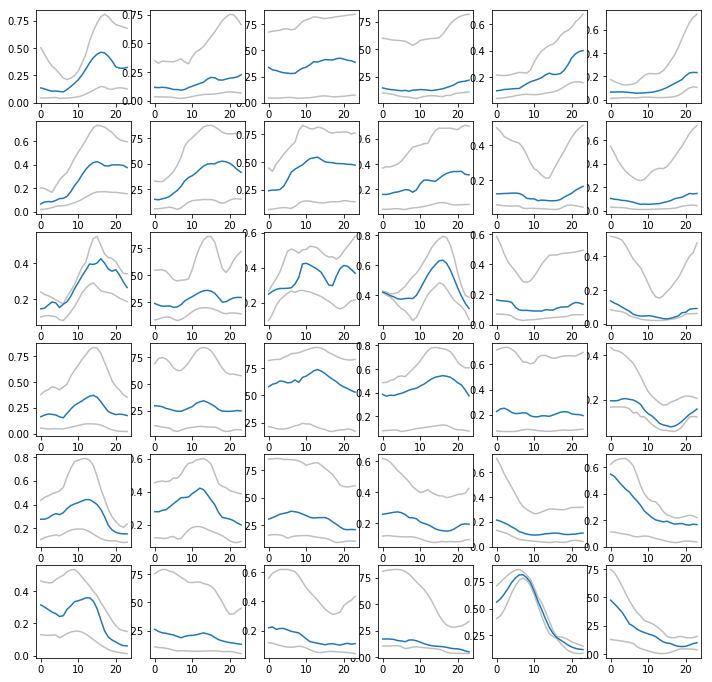

In [162]:
win_map = som.win_map(pv_array)

plt.figure(figsize=(16, 16))
the_grid = GridSpec(8, 8)
for position in win_map.keys():
    plt.subplot(the_grid[6-position[1], position[0]])
    plt.plot(np.min(win_map[position], axis=0), color='gray', alpha=.5)
    plt.plot(np.median(win_map[position], axis=0))
    plt.plot(np.max(win_map[position], axis=0), color='gray', alpha=.5)
# plt.savefig('resulting_images/time_series.png')
plt.show()


In [159]:
type(win_map.keys())

dict_keys

In [166]:
for position in win_map.keys():
    print(position)
    median_day = np.median(win_map[position], axis=0)
    print(len(win_map[position]))
    n_days = len(win_map[position])
    
    print(cdist(median_day.reshape(1,-1), np.array(win_map[position]).reshape(len(win_map[position]),-1)))
    distance = cdist(median_day.reshape(1,-1), np.array(win_map[position]).reshape(len(win_map[position]),-1)).flatten()
    sorted_args = np.argsort(distance)
    sorted_dist = np.sort(distance)
    print(sorted_args)
    print(sorted_dist)
    k_smallest = np.argpartition(distance, 0)[0]
    print(k_smallest)
    print(win_map[position][k_smallest])

(3, 5)
12
[[1.55012495 2.43398019 0.26047866 0.2442345  0.11855016 0.1254698
  0.06251888 0.15615508 0.33770742 1.31916083 0.25819737 0.0410373 ]]
[11  6  4  5  7  3 10  2  8  9  0  1]
[0.0410373  0.06251888 0.11855016 0.1254698  0.15615508 0.2442345
 0.25819737 0.26047866 0.33770742 1.31916083 1.55012495 2.43398019]
11
[0.124  0.1217 0.1247 0.1214 0.1175 0.1169 0.1167 0.1221 0.1325 0.1368
 0.1355 0.1311 0.1275 0.1212 0.1201 0.1263 0.1363 0.1537 0.1734 0.1874
 0.2006 0.2016 0.2054 0.2266]
(2, 2)
19
[[0.95264458 0.30084282 0.16761605 0.43933729 0.90309761 0.89809555
  0.19158619 0.3167619  1.49001833 2.13453855 1.45567253 0.13874833
  0.94495041 0.60583718 0.35850371 2.00106974 0.31209114 1.06686922
  0.22536036]]
[11  2  6 18  1 16  7 14  3 13  5  4 12  0 17 10  8 15  9]
[0.13874833 0.16761605 0.19158619 0.22536036 0.30084282 0.31209114
 0.3167619  0.35850371 0.43933729 0.60583718 0.89809555 0.90309761
 0.94495041 0.95264458 1.06686922 1.45567253 1.49001833 2.00106974
 2.13453855]
11
[